In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
pdb_ids = ['2LEA', '2K52', '2LTM', '2KD0', '2LF2']
pdb_id = pdb_ids[4]

In [20]:
df = pd.read_csv('data/' + pdb_id + '_15N.list', header=0, index_col=None, sep='\s+')

df.drop(columns='Height', inplace=True)
df.rename({
    'Assignment': 'label',
    'Data': 'height',
    'w1': 'N',
    'w2': 'Hn',
    'w3': 'H'
}, axis=1, inplace=True)
df['height'] = np.abs(df.height)

df.insert(0, 'noe', df.label.apply(lambda s: s.split('-')[-1]))
df.insert(0, 'res', df.label.apply(lambda s: s.split('-')[0]))

df['noe_res'] = df.noe.apply(lambda s: s.split('H')[0])
df.loc[df.noe_res == '', 'noe_res'] = df.loc[df.noe_res == ''].res
df['noe_res'] = df.noe_res.str.removesuffix('N')
df['res'] = df.res.str.removesuffix('N')
df.drop(columns='label', inplace=True)
df['inter'] = df.noe_res != df.res

df['resnum'] = df['res'].str.extract('(\d+)', expand=False).fillna(0).astype(int)
df['noe_resnum'] = df['noe_res'].str.extract('(\d+)', expand=False).fillna(0).astype(int)

df['res_diff'] = df['resnum'] - df['noe_resnum']
df['atom_type'] = df['noe'].str.extract(r'(H[A-Za-z]?)')
df = df.assign(atom_type_pos=lambda s: s.atom_type + '_i-' + s.res_diff.astype('str'))
df['atom_type_pos'] = df.atom_type_pos.str.replace('--', '+')
df['atom_type_pos'] = df.atom_type_pos.str.replace('-0', '')

df = df[df.atom_type=="HA"]

Remove any protons but the HA from w3 
 
Plot the distribution of 
- Intensity rank of N(i)-H(i)-HA(i) wrt any N(i)-H(i)-HA([0-9]+)
- Relative intensity of N(i)-H(i)-HA(i) wrt any N(i)-H(i)-HA([0-9]+)
- Intensity rank of N(i)-H(i)-HA(i-1) wrt any N(i)-H(i)-HA([0-9]+)
- Relative intensity of N(i)-H(i)-HA(i-1) wrt any N(i)-H(i)-HA([0-9]+)

In [21]:
max_height_within_spin_system = df.groupby('res')['height'].transform('max')
df.insert(6, 'rel_height', df.height / max_height_within_spin_system)
df

,res,noe,N,Hn,H,height,rel_height,noe_res,inter,resnum,noe_resnum,res_diff,atom_type,atom_type_pos
1,T3,R2HA,114.2,8.42,4.46,2354,1.000000,R2,True,3,2,1,HA,HA_i-1
7,T3,HA,114.2,8.42,4.34,745,0.316483,T3,False,3,3,0,HA,HA_i
12,D4,T3HA,120.9,8.63,4.34,8382,1.000000,T3,True,4,3,1,HA,HA_i-1
16,D4,HA,120.9,8.63,4.57,6638,0.791935,D4,False,4,4,0,HA,HA_i
21,L5,D4HA,121.9,7.58,4.57,13052,1.000000,D4,True,5,4,1,HA,HA_i-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3689,L168,K167HA,123.0,8.24,4.28,18332,1.000000,K167,True,168,167,1,HA,HA_i-1
3695,L168,HA,123.0,8.24,4.31,12256,0.668558,L168,False,168,168,0,HA,HA_i
3703,E169,L168HA,120.9,8.33,4.31,8139,1.000000,L168,True,169,168,1,HA,HA_i-1
3710,E169,HA,120.9,8.33,4.20,3393,0.416882,E169,False,169,169,0,HA,HA_i


In [22]:
dfh = df.drop_duplicates()  # This drops only the GlyHA(2,3) peaks which can not be distinguished

dfh['rank'] = dfh[['res', 'atom_type_pos', 'height']].groupby(['res'], as_index=False)["height"].rank(
    method='dense', ascending=False)
rank_counts = dfh.groupby(['atom_type_pos', 'rank']).size().unstack(fill_value=0)
rank_counts.insert(3, "4+", rank_counts.iloc[:, 3:].sum(axis=1))
rank_counts = rank_counts.iloc[:, :4]
rank_counts.index.name = "Atom name"
rank_counts.columns = ["1st highest", "2nd highest", "3rd highest", "4th or lower"]

In [23]:
rank_counts

,1st highest,2nd highest,3rd highest,4th or lower
Atom name,,,,
HA_i,83,72,31,12
HA_i+1,4,16,29,99
HA_i+10,0,1,0,5
HA_i+100,0,1,0,0
HA_i+101,0,0,0,1
...,...,...,...,...
HA_i-7,0,0,1,4
HA_i-8,0,1,1,3
HA_i-9,0,1,1,2


Plotting relative intensities of HAi

<Axes: ylabel='Frequency'>

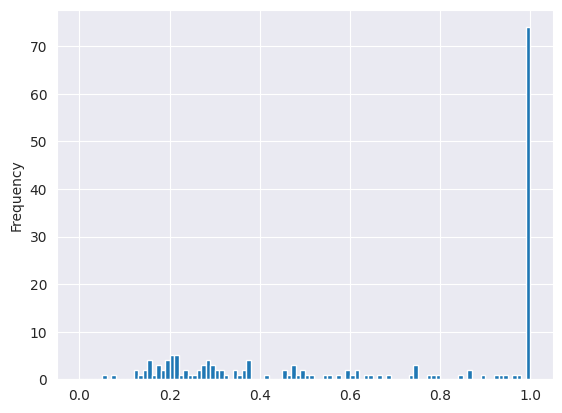

In [27]:
df_HAi = df.loc[df.noe == "HA"]

df_HAi.rel_height.plot(kind="hist", bins=100, range=(0, 1));

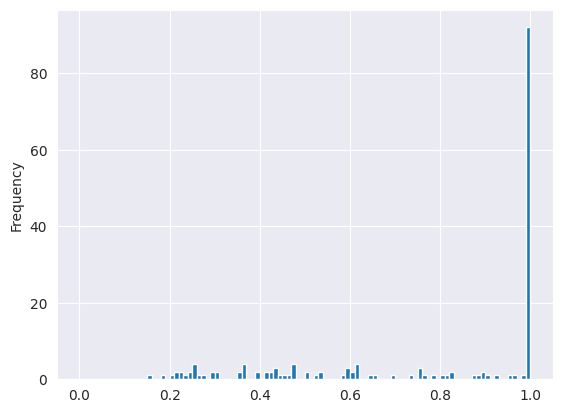

In [28]:
df_HAim1 = df.loc[df.res_diff == 1]

df_HAim1.rel_height.plot(kind="hist", bins=100, range=(0, 1));

In [29]:
df.height.abs()

1        2354
7         745
12       8382
16       6638
21      13052
        ...  
3689    18332
3695    12256
3703     8139
3710     3393
3717      382
Name: height, Length: 885, dtype: int64